In [1]:
# Standard Library
import os
import sys
import csv
import random

# Third-Party Libraries
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import segmentation_models_pytorch as smp
from monai.metrics import compute_hausdorff_distance

# PyTorch Components
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

# Rich Components
from rich.console import Console
from rich.progress import Progress, BarColumn, TextColumn, TimeElapsedColumn, TimeRemainingColumn
from rich.table import Table, Column
from rich.live import Live
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
# Configuration
CONFIG = {
    "labeled_img": "dataset/labeled_data/images",
    "labeled_mask": "dataset/labeled_data/labels",
    "unlabeled_img": "dataset/unlabeled_data/images",
    "epochs": 50,
    "batch_size": 2,
    "lr": 1e-3,
    "num_classes": 3,
    "save_dir": "models",
    "num_workers": 2,
    "encoder": "efficientnet-b5",
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Transforms
transform_labeled = T.Compose([
    # T.Resize((384, 384)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(0.2, 0.2, 0.2, 0.1),
    T.ToTensor(),
])

transform_unlabeled = T.Compose([
    # T.Resize((384, 384)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(0.3, 0.3, 0.3, 0.2),
    T.ToTensor(),
])

transform_mask = T.Compose([
    # T.Resize((384, 384), interpolation=Image.NEAREST),
    T.PILToTensor(),
    lambda x: x.squeeze(0).long()
])

# Dataset
class CervicalDataset(Dataset):
    def __init__(self, img_dir, mask_dir=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) 
                            if f.endswith(('.png', '.jpg'))])
        if mask_dir:
            self.masks = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) 
                               if f.endswith(('.png', '.jpg'))])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")  # Properly indented
        if self.mask_dir:
            mask = Image.open(self.masks[idx]).convert("L")
                
            return transform_labeled(image), transform_mask(mask)
        return transform_unlabeled(image)

In [3]:
device = torch.device(CONFIG['device'])
os.makedirs(CONFIG['save_dir'], exist_ok=True)

# Initialize datasets and loaders
labeled_ds = CervicalDataset(CONFIG['labeled_img'], CONFIG['labeled_mask'])
unlabeled_ds = CervicalDataset(CONFIG['unlabeled_img'])

In [5]:
labeled_loader = DataLoader(labeled_ds, batch_size=CONFIG['batch_size'], 
                          shuffle=True, num_workers=CONFIG['num_workers'], pin_memory=True)
unlabeled_loader = DataLoader(unlabeled_ds, batch_size=CONFIG['batch_size']*2,
                             shuffle=True, num_workers=CONFIG['num_workers'], pin_memory=True)

In [6]:
labeled_loader.show_batch()

AttributeError: 'DataLoader' object has no attribute 'show_batch'

In [ ]:
# Semi-Supervised Model Wrapper
class SemiSupervisedModel(nn.Module):
    def __init__(self, num_classes=3, alpha=0.999):
        super().__init__()
        self.student = smp.DeepLabV3Plus(
            encoder_name=CONFIG['encoder'],
            encoder_weights='imagenet',
            in_channels=3,
            classes=num_classes,
            activation=None
        )
        self.teacher = smp.DeepLabV3Plus(
            encoder_name=CONFIG['encoder'],
            encoder_weights='imagenet',
            in_channels=3,
            classes=num_classes,
            activation=None
        )
        self._init_teacher()
        self.alpha = alpha
        self.teacher.eval()  # Crucial addition

    def _init_teacher(self):
        with torch.no_grad():
            for t_param, s_param in zip(self.teacher.parameters(), self.student.parameters()):
                t_param.data.copy_(s_param.data)
                
    @torch.no_grad()
    def update_teacher(self, global_step):
        # Improved alpha scheduling
        alpha = min(self.alpha, 1 - (1 / (global_step/100 + 1)))  # Better initialization
        for t_param, s_param in zip(self.teacher.parameters(), self.student.parameters()):
            t_param.data.mul_(alpha).add_(s_param.data.detach(), alpha=1-alpha)  # Add detach()

    def forward(self, x):
        return self.student(x)

# Modified HD calculation in the training loop

def calculate_hd(pred, target, device):
    hd = torch.tensor(0.0, device=device)
    try:
        pred_mask = (pred > 0).unsqueeze(1).float()
        target_mask = (target > 0).unsqueeze(1).float()
        
        hd_values = []
        for p, t in zip(pred_mask, target_mask):
            hd_batch = compute_hausdorff_distance(
                p.unsqueeze(0),
                t.unsqueeze(0),
                percentile=95,
                include_background=False,
                directed=False
            )
            if not torch.isnan(hd_batch):
                hd_values.append(hd_batch)
        
        if hd_values:
            hd = torch.mean(torch.stack(hd_values))
    except Exception as e:
        sys.stdout.write(f"HD Error: {str(e)}\n")
    
    return hd

# Loss Functions
def compute_sat_loss(student_feats, teacher_feats, temperature=0.1):
    # Add feature normalization and stability improvements
    student_feats = F.normalize(student_feats, p=2, dim=1)
    teacher_feats = F.normalize(teacher_feats, p=2, dim=1)
    
    # Clamp similarities to prevent numerical issues
    sim_matrix = torch.mm(student_feats, teacher_feats.t())
    sim_matrix = torch.clamp(sim_matrix, min=-1.0, max=1.0)
    sim_matrix /= temperature
    
    # More stable positive/negative separation
    pos_sim = torch.diag(sim_matrix)
    neg_sim = torch.logsumexp(sim_matrix, dim=1) - pos_sim  # Numerically stable
    
    return - (pos_sim - neg_sim).mean()

class CombinedLoss(nn.Module):
    def __init__(self, class_weights=None):
        super().__init__()
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)
        
    def forward(self, preds, targets):
        ce = self.ce_loss(preds, targets)
        preds_soft = F.softmax(preds, dim=1)
        targets_oh = F.one_hot(targets, num_classes=CONFIG['num_classes']).permute(0,3,1,2).float()
        intersection = (preds_soft * targets_oh).sum(dim=(2,3))
        union = preds_soft.sum(dim=(2,3)) + targets_oh.sum(dim=(2,3))
        dice = 1 - (2 * intersection + 1e-6) / (union + 1e-6)
        return ce + dice.mean()

def train():
    device = torch.device(CONFIG['device'])
    os.makedirs(CONFIG['save_dir'], exist_ok=True)

    # Delete existing CSV file
    csv_path = os.path.join(CONFIG['save_dir'], 'training_metrics.csv')
    if os.path.exists(csv_path):
        os.remove(csv_path)

    # Initialize datasets and loaders
    labeled_ds = CervicalDataset(CONFIG['labeled_img'], CONFIG['labeled_mask'])
    unlabeled_ds = CervicalDataset(CONFIG['unlabeled_img'])
    
    # Calculate class weights
    class_counts = torch.zeros(CONFIG['num_classes'])
    for _, mask in labeled_ds:
        class_counts += torch.bincount(mask.flatten(), minlength=CONFIG['num_classes'])
    class_weights = (1.0 / (class_counts / class_counts.sum())).to(device)
    
    labeled_loader = DataLoader(labeled_ds, batch_size=CONFIG['batch_size'], 
                              shuffle=True, num_workers=CONFIG['num_workers'], pin_memory=True)
    unlabeled_loader = DataLoader(unlabeled_ds, batch_size=CONFIG['batch_size']*2,
                                 shuffle=True, num_workers=CONFIG['num_workers'], pin_memory=True)
    
    # Initialize model and optimizer
    model = SemiSupervisedModel(num_classes=CONFIG['num_classes']).to(CONFIG['device'])
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'])
    sup_criterion = CombinedLoss(class_weights)
    unsup_criterion = CombinedLoss()

    # CSV setup
    csv_header = ['Epoch', 'Loss', 'Sup Loss', 'Unsup Loss', 'SAT Loss',
                 'FG Acc', 'Precision', 'Recall', 'F1', 'Dice', 'HD']
    metric_keys = ['total', 'sup', 'unsup', 'sat',
                  'fg_acc', 'precision', 'recall', 'f1', 'dice', 'hd']
    
    # Rich components setup
    console = Console()
    progress = Progress(
        TextColumn("[bold blue]{task.description}"), 
        BarColumn(bar_width=None),
        TextColumn("[progress.percentage]{task.percentage:>3.0f}%"),
        TimeRemainingColumn(),
        TimeElapsedColumn(),
        transient=True,
        expand=True
    )
    
    # Progress tasks
    overall_task = progress.add_task("Total Training", total=CONFIG['epochs'])
    epoch_task = progress.add_task("Current Epoch", total=min(len(labeled_loader), len(unlabeled_loader)), visible=False)
    
    # Metrics table setup
    metric_columns = [
        Column("Loss", justify="center", min_width=8),
        Column("Sup Loss", justify="center", min_width=8),
        Column("Unsup Loss", justify="center", min_width=10),
        Column("SAT Loss", justify="center", min_width=8),
        Column("FG Acc", justify="center", min_width=8),
        Column("Precision", justify="center", min_width=9),
        Column("Recall", justify="center", min_width=7),
        Column("F1", justify="center", min_width=6),
        Column("Dice", justify="center", min_width=6),
        Column("HD", justify="center", min_width=6)
    ]
    
    table = Table(
        Column("Epoch", justify="right", min_width=5),
        *metric_columns,
        show_header=True,
        header_style="bold magenta",
        expand=True,
        box=None
    )

    # Live display layout
    layout = Table.grid(expand=True)
    layout.add_row(progress)
    layout.add_row(table)
    
    with Live(layout, console=console, refresh_per_second=10, vertical_overflow="visible") as live:
        best_dice = 0.0
        global_step = 0
        
        for epoch in range(CONFIG['epochs']):
            model.train()
            metrics = {
                'total': [], 'sup': [], 'unsup': [], 'sat': [],
                'fg_acc': [], 'precision': [], 'recall': [], 'f1': [],
                'dice': [], 'hd': []
            }
            
            progress.reset(epoch_task)
            progress.update(epoch_task, visible=True)
            
            # Dynamic parameters
            current_thresh = 0.65 + min(epoch/CONFIG['epochs'], 1)*0.25
            current_lambda_unsup = min(epoch/10 * 0.5, 0.5)
            current_lambda_sat = 0.5 * (1 - epoch/CONFIG['epochs'])  # Increased weight
            
            # Batch iteration
            for (labeled_x, labeled_y), unlabeled_x in zip(labeled_loader, unlabeled_loader):
                labeled_x, labeled_y = labeled_x.to(device), labeled_y.to(device)
                unlabeled_x = unlabeled_x.to(device)
                
                # ========== Supervised Forward ==========
                student_preds = model(labeled_x)
                sup_loss = sup_criterion(student_preds, labeled_y)
                
                # ========== Unsupervised Forward ==========
                with torch.no_grad():
                    # Teacher predictions
                    teacher_preds = model.teacher(unlabeled_x)
                    pseudo_probs = F.softmax(teacher_preds, dim=1)
                    max_probs, pseudo_labels = torch.max(pseudo_probs, dim=1)
                    mask = (max_probs > current_thresh).float()
                    
                    # Teacher features
                    t_features = model.teacher.encoder(unlabeled_x)[-1]
                    t_features = F.adaptive_avg_pool2d(t_features, (1, 1)).flatten(1)
                
                # Student features (with gradients)
                s_features = model.student.encoder(unlabeled_x)[-1]
                s_features = F.adaptive_avg_pool2d(s_features, (1, 1)).flatten(1)
                
                # ========== Loss Calculations ==========
                # Feature alignment loss
                sat_loss = compute_sat_loss(s_features, t_features)
                
                # Unsupervised loss
                unsup_loss = 0.0
                if mask.sum() > 0:
                    student_u_preds = model(unlabeled_x)
                    unsup_loss = unsup_criterion(student_u_preds, pseudo_labels) * mask.mean()
                
                # Total loss
                total_loss = sup_loss + current_lambda_unsup*unsup_loss + current_lambda_sat*sat_loss
                
                # ========== Optimization ==========
                optimizer.zero_grad()
                total_loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                model.update_teacher(global_step)
                global_step += 1
                
                # ========== Metrics Calculation ==========
                with torch.no_grad():
                    pred = student_preds.argmax(1)
                    target = labeled_y
                    
                    # Foreground metrics
                    fg_mask = target != 0
                    fg_acc = (pred[fg_mask] == target[fg_mask]).float().mean() if fg_mask.any() else torch.tensor(0.0)
                    
                    # Precision/Recall/F1
                    tp = ((pred > 0) & (target > 0)).sum()
                    fp = ((pred > 0) & (target == 0)).sum()
                    fn = ((pred == 0) & (target > 0)).sum()
                    
                    epsilon = 1e-7
                    precision = tp / (tp + fp + epsilon)
                    recall = tp / (tp + fn + epsilon)
                    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
                    
                    # Dice score
                    dice = (2 * (pred == target).sum() / 
                           (pred.numel() + target.numel() + epsilon))
                    
                    # Hausdorff Distance
                    hd = calculate_hd(pred, target, device)
                
                # Update metrics
                metrics['total'].append(round(total_loss.item(), 2))
                metrics['sup'].append(round(sup_loss.item(), 2))
                metrics['unsup'].append(round(unsup_loss.item() if unsup_loss !=0 else 0.0, 2))
                metrics['sat'].append(round(sat_loss.item(), 2))
                metrics['fg_acc'].append(round(fg_acc.item(), 2))
                metrics['precision'].append(round(precision.item(), 2))
                metrics['recall'].append(round(recall.item(), 2))
                metrics['f1'].append(round(f1.item(), 2))
                metrics['dice'].append(round(dice.item(), 2))
                metrics['hd'].append(round(hd.item(), 2))
                
                # Debug prints
                if global_step % 50 == 0:
                    console.print(f"\nStep {global_step}:")
                    console.print(f"SAT Loss: {sat_loss.item():.4f}")
                    console.print(f"Features - Student: μ={s_features.mean().item():.4f} ±{s_features.std().item():.4f}")
                    console.print(f"Features - Teacher: μ={t_features.mean().item():.4f} ±{t_features.std().item():.4f}")
                
                progress.update(epoch_task, advance=1)

            # ========== Epoch Statistics ==========
            epoch_stats = [str(epoch+1)]
            for k in metric_keys:
                mean = round(np.mean(metrics[k]), 2)
                std = round(np.std(metrics[k]), 2)
                formatted = f"{mean:.2f} ± {std:.2f}"
                epoch_stats.append(formatted)
            
            # Update table and save model
            table.add_row(*epoch_stats)
            with open(csv_path, 'a', newline='') as f:
                writer = csv.writer(f)
                if epoch == 0:
                    writer.writerow(csv_header)
                writer.writerow([epoch+1] + [f"{mean:.2f} ± {std:.2f}" 
                                           for mean, std in zip(
                                               [round(np.mean(metrics[k]), 2) for k in metric_keys],
                                               [round(np.std(metrics[k]), 2) for k in metric_keys])
                                           ])
            
            # Update progress
            progress.update(overall_task, advance=1)
            progress.update(epoch_task, visible=False)
            torch.save(model.state_dict(), os.path.join(CONFIG['save_dir'], f"epoch_{epoch+1}.pth"))
            torch.save(model.student.state_dict(), os.path.join(CONFIG['save_dir'], f"epoch_{epoch+1}_student.pth"))
            scheduler.step()
    
    console.print("[bold green]Training completed![/bold green]")

if __name__ == "__main__":
    train()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117M/117M [00:02<00:00, 57.8MB/s]


Output()

Step 50:

SAT Loss: -8.4849

Features - Student: μ=0.0080 ±0.7512

Features - Teacher: μ=0.0070 ±0.7270

Step 100:

SAT Loss: -9.3919

Features - Student: μ=0.0079 ±0.8354

Features - Teacher: μ=0.0090 ±0.9216

Step 150:

SAT Loss: -9.6292

Features - Student: μ=0.0068 ±0.9218

Features - Teacher: μ=0.0091 ±0.8799

Step 200:

SAT Loss: -9.6227

Features - Student: μ=0.0082 ±0.8653

Features - Teacher: μ=0.0049 ±0.8639

Step 250:

SAT Loss: -9.6383

Features - Student: μ=0.0055 ±1.3115

Features - Teacher: μ=0.0071 ±1.2366

Step 300:

SAT Loss: -9.4650

Features - Student: μ=0.0010 ±1.1292

Features - Teacher: μ=0.0124 ±1.1152

Step 350:

SAT Loss: -9.3870

Features - Student: μ=0.0088 ±1.2527

Features - Teacher: μ=-0.0016 ±1.1416

Step 400:

SAT Loss: -9.7954

Features - Student: μ=0.0147 ±1.2315

Features - Teacher: μ=0.0083 ±1.3809

Step 450:

SAT Loss: -9.7112

Features - Student: μ=0.0119 ±1.4429

Features - Teacher: μ=0.0018 ±1.4337

Step 500:

SAT Loss: -9.8103

Features - Student: μ=0.0087 ±1.7542

Features - Teacher: μ=0.0007 ±1.4952

Step 550:

SAT Loss: -9.8971

Features - Student: μ=0.0087 ±1.8277

Features - Teacher: μ=0.0087 ±1.7736

Step 600:

SAT Loss: -9.8582

Features - Student: μ=0.0002 ±1.4877

Features - Teacher: μ=0.0107 ±1.6384

Step 650:

SAT Loss: -9.8488

Features - Student: μ=0.0086 ±1.7065

Features - Teacher: μ=0.0182 ±1.5700

Step 700:

SAT Loss: -9.8789

Features - Student: μ=0.0082 ±1.3184

Features - Teacher: μ=0.0086 ±1.6414

Step 750:

SAT Loss: -9.8985

Features - Student: μ=0.0011 ±1.5877

Features - Teacher: μ=-0.0042 ±1.4985

Step 800:

SAT Loss: -9.6419

Features - Student: μ=0.0101 ±1.5746

Features - Teacher: μ=0.0064 ±1.4606

Step 850:

SAT Loss: -9.7797

Features - Student: μ=0.0064 ±1.7708

Features - Teacher: μ=0.0108 ±1.7947

Step 900:

SAT Loss: -9.6932

Features - Student: μ=-0.0072 ±1.5634

Features - Teacher: μ=0.0109 ±1.7672

Step 950:

SAT Loss: -9.9514

Features - Student: μ=0.0086 ±1.8823

Features - Teacher: μ=0.0050 ±1.7845

Step 1000:

SAT Loss: -9.8439

Features - Student: μ=0.0139 ±1.4334

Features - Teacher: μ=0.0203 ±1.6471

Step 1050:

SAT Loss: -9.9022

Features - Student: μ=0.0072 ±1.5099

Features - Teacher: μ=0.0131 ±1.5540

Step 1100:

SAT Loss: -9.8632

Features - Student: μ=-0.0010 ±1.5870

Features - Teacher: μ=0.0020 ±1.5951

Step 1150:

SAT Loss: -9.8986

Features - Student: μ=-0.0004 ±1.7212

Features - Teacher: μ=0.0043 ±1.6703

Step 1200:

SAT Loss: -9.9019

Features - Student: μ=-0.0006 ±1.7642

Features - Teacher: μ=0.0142 ±1.9199

Step 1250:

SAT Loss: -9.8914

Features - Student: μ=0.0050 ±1.5032

Features - Teacher: μ=0.0078 ±1.6092

Training completed!

In [2]:
def generate_and_save_masks(model, unlabeled_img_dir, device="cuda"):
    """Generate masks for unlabeled images and save in parallel 'labels' folder"""
    # Create labels directory at same level as images
    base_dir = os.path.dirname(unlabeled_img_dir)
    labels_dir = os.path.join(base_dir, "labels")
    os.makedirs(labels_dir, exist_ok=True)
    
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
    ])
    
    model.eval()
    image_paths = [f for f in os.listdir(unlabeled_img_dir) 
                  if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    with torch.no_grad():
        for img_name in tqdm(image_paths, desc="Generating Labels"):
            img_path = os.path.join(unlabeled_img_dir, img_name)
            image = Image.open(img_path).convert("RGB")
            input_tensor = transform(image).unsqueeze(0).to(device)
            
            # Predict and save
            output = model(input_tensor)
            mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy().astype(np.uint8)
            
            # Save with same name in labels folder
            base_name = os.path.splitext(img_name)[0]
            mask_path = os.path.join(labels_dir, f"{base_name}.png")
            Image.fromarray(mask).save(mask_path)

def visualize_predictions(image_dir, labels_dir=None, model=None, num_samples=4, device="cuda"):
    """Visualize images with ground truth/predicted labels"""
    # Create dataset
    dataset = CervicalDataset(image_dir, labels_dir)
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    
    # Get batch
    images, labels = next(iter(loader)) if labels_dir else (next(iter(loader)), None)
    
    # Get predictions if model provided
    if model:
        model.eval()
        with torch.no_grad():
            inputs = images.to(device)
            outputs = model(inputs)
            pred_labels = torch.argmax(outputs.cpu(), dim=1)
    
    # Setup plot
    plt.figure(figsize=(20, 10 if model else 5))
    cols = 3 if (model and labels_dir) else 2
    class_colors = {0: [0,0,0], 1: [255,0,0], 2: [0,255,0]}  # Update based on classes
    
    for i in range(num_samples):
        # Original Image
        plt.subplot(num_samples, cols, i*cols + 1)
        img = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis('off')
        
        # Ground Truth Labels (if available)
        if labels_dir and labels is not None:
            plt.subplot(num_samples, cols, i*cols + 2)
            label = labels[i].numpy()
            colored_label = np.zeros((*label.shape, 3), dtype=np.uint8)
            for class_id, color in class_colors.items():
                colored_label[label == class_id] = color
            plt.imshow(colored_label)
            plt.title("Ground Truth")
            plt.axis('off')
        
        # Predicted Labels (if model provided)
        if model:
            col_idx = i*cols + (3 if labels_dir else 2)
            plt.subplot(num_samples, cols, col_idx)
            pred = pred_labels[i].numpy()
            colored_pred = np.zeros((*pred.shape, 3), dtype=np.uint8)
            for class_id, color in class_colors.items():
                colored_pred[pred == class_id] = color
            
            plt.imshow(colored_pred)
            plt.title("Predicted Labels")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [3]:
# After training
device="cuda"

In [4]:
model = SemiSupervisedModel(num_classes=3).to(device)
model.load_state_dict(torch.load("models/epoch_50.pth"))  # Load best model

<All keys matched successfully>

In [9]:
# Generate labels for unlabeled data
generate_and_save_masks(
    model=model,
    unlabeled_img_dir="dataset/unlabeled_data/images",
    device=device
)

Generating Labels: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:11<00:00, 39.69it/s]


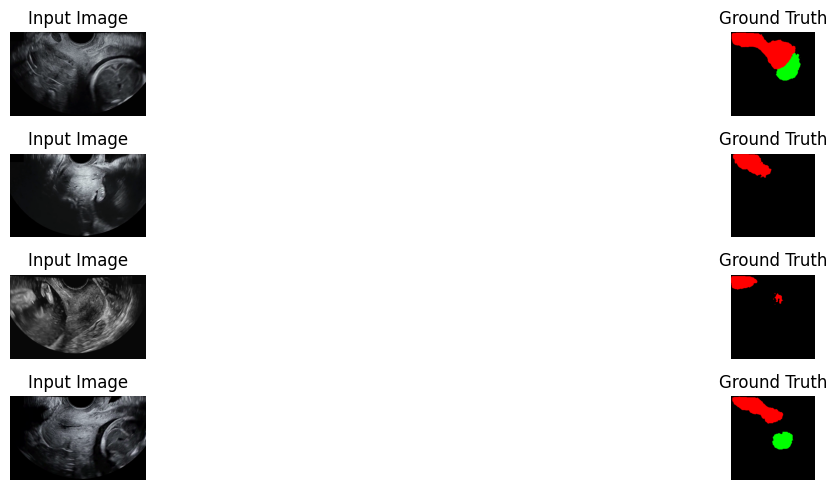

In [15]:
# Visualize unlabeled data with generated labels
visualize_predictions(
    image_dir="dataset/unlabeled_data/images",
    labels_dir="dataset/unlabeled_data/labels",
    num_samples=4
)